#### 라이브러리 불러오기

In [1]:
import os
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
import requests

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from model_evaluation import regression_evaluation, f_importances, user_mape

2023-08-28 18:54:49.220280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 설정

##### VWorld

In [2]:
VW_KEY_PATH = os.path.join(os.path.expanduser('~'), 'projects', 'vworld_key.txt')
with open(VW_KEY_PATH, 'r') as _key_file:
    _vw_lines = _key_file.readlines()
VW_KEY = _vw_lines[0].replace('\n', '')

In [3]:
VW_TILE_TYPE = 'png'
VW_ATTR = 'Vworld'

##### 차트 한글

In [4]:
import platform

_os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
_font_path = 'c:/Windows/Fonts/malgun.ttf' if _os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
_font_family = fm.FontProperties(fname=_font_path).get_name()

# font 설정
plt.rcParams['font.family'] = _font_family

# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [_font_family]

_fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, _fe)

#### 지도에 터빈위치 표시

In [5]:
turbin_info = {
    'a': { 'lat': 35.486483143070764, 'lon': 126.34213114581526, 'name': 'A'},
    'b': { 'lat': 35.48131840227845,  'lon': 126.33507818977857, 'name': 'B'},
    'c': { 'lat': 35.476172884715325, 'lon': 126.32890690366085, 'name': 'C'},
    'd': { 'lat': 35.471026994051186, 'lon': 126.32273651737738, 'name': 'D'},
}

In [6]:
VW_LATS = [info['lat'] for info in turbin_info.values()]
VW_LONS = [info['lon'] for info in turbin_info.values()]
VW_MAP_CENTER = [(min(VW_LATS)+max(VW_LATS))/2, (min(VW_LONS)+max(VW_LONS))/2]


In [7]:
VW_LAYER = 'Base'
VW_TILES_URL = \
    f'http://api.vworld.kr/req/wmts/1.0.0/' \
    f'{VW_KEY}/{VW_LAYER}/{{z}}/{{y}}/{{x}}.{VW_TILE_TYPE}'

In [8]:
base_map = folium.Map(
    location=VW_MAP_CENTER, zoom_start=12,
    tiles=VW_TILES_URL, attr=VW_ATTR
)

for _, _value in turbin_info.items():
    folium.Marker(
        location=[_value['lat'], _value['lon']],
        popup=f'{_value["name"]}-Turbin',
    ).add_to(base_map)

base_map

#### 데이터 불러오기

In [9]:
_PATH_BASE = os.path.join(os.getcwd(), 'data', '41-turbin')
get_path = lambda turbin: os.path.join(_PATH_BASE, f'{turbin}_turbin.csv')

In [10]:
df_a = pd.read_csv(get_path('a'))
df_b = pd.read_csv(get_path('b'))
df_c = pd.read_csv(get_path('c'))
df_d = pd.read_csv(get_path('d'))

#### 데이터 확인

In [11]:
# 결측치 확인
df_a.isna().sum()       

# 없음: 결측치는 -1로 들어온것 같음

TURBINE_TIME    0
WIND_SPEED      0
WIND_DIR        0
ACTIVE_POWER    0
month           0
hour            0
dtype: int64

In [12]:
# 음수인 row 갯 수 확인
non_value_counts = (df_a.drop('TURBINE_TIME', axis=1) < 0).sum()

# 풍속이 음수인 갯 수: 17540, 이건 모두 NaN(-1)으로 볼 수 있음
# 풍향이 음수인 갯 수: 20088, 거의 모든 데이터, 풍향은 음수일 수도 있음
# 발전량이 음수인 갯 수: 17540, 풍속과 동일한걸 보면 같이 NaN(-1) 처리하면 될듯

In [13]:
target_col = 'ACTIVE_POWER'

In [14]:
df_a_nn = df_a[df_a[target_col] != -1]

In [15]:
df_b_nn = df_b[df_b[target_col] != -1]
df_c_nn = df_c[df_c[target_col] != -1]
df_d_nn = df_d[df_d[target_col] != -1]

##### 풍속 vs 발전량 차트

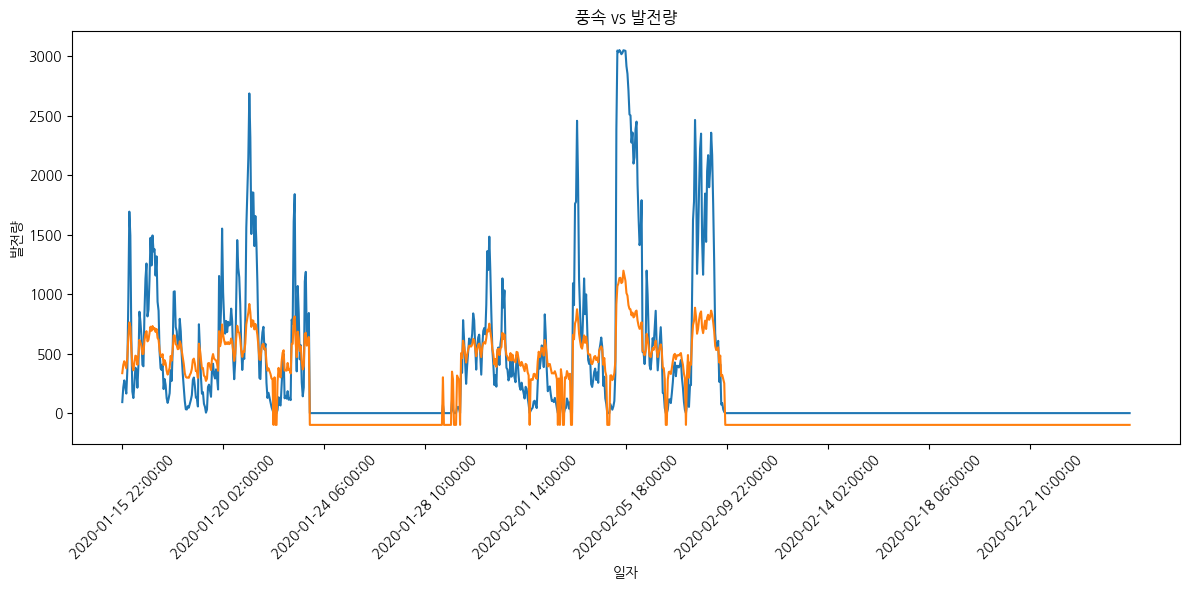

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df_b['TURBINE_TIME'][:1000], df_b[target_col][:1000])
plt.plot(df_b['TURBINE_TIME'][:1000], df_b['WIND_SPEED'][:1000]*100)
plt.xlabel('일자')
plt.ylabel('발전량')
plt.xticks(df_b['TURBINE_TIME'][:1000:100], rotation=45)
plt.title('풍속 vs 발전량')
plt.tight_layout()
plt.show()

In [20]:
df_b[target_col].max()

3092.2000000000003

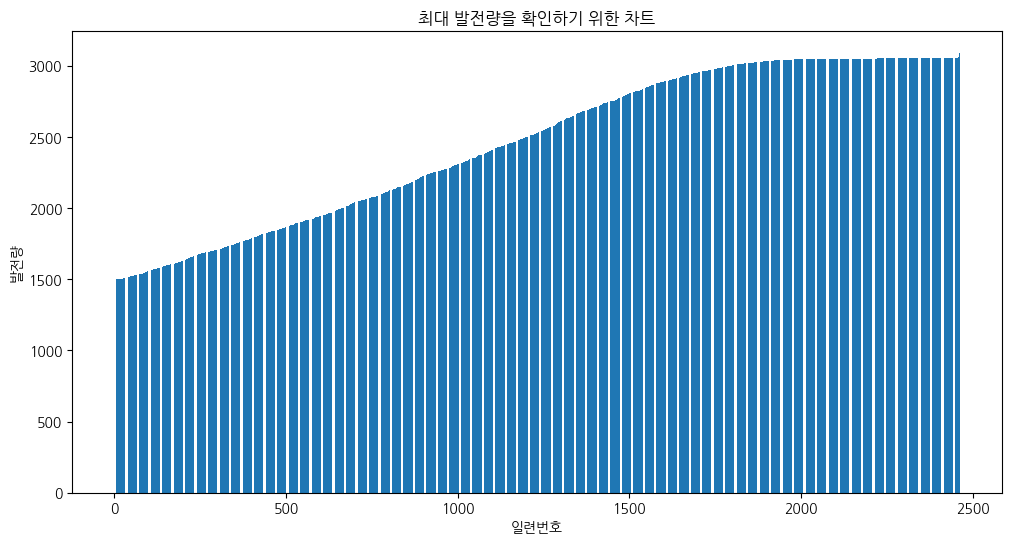

In [24]:
df_b_1500 = df_b[df_b[target_col]>1500]
unique_values = df_b_1500['ACTIVE_POWER'].unique()
unique_values.sort()

x_ticks = range(len(unique_values))
plt.figure(figsize=(12,6))
plt.bar(x_ticks, unique_values)
# plt.xticks(x_ticks, unique_values)
plt.xlabel('일련번호')
plt.ylabel('발전량')
plt.title('최대 발전량을 확인하기 위한 차트')
plt.show()

In [26]:
unique_values[-15:]

array([3054.68333333, 3054.72333333, 3054.96833333, 3055.06833333,
       3055.2375    , 3055.7490566 , 3055.94545455, 3056.65853659,
       3056.7969697 , 3058.59111111, 3058.59444444, 3059.548     ,
       3060.93571429, 3074.85      , 3092.2       ])